Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=Warning)

## 0. Загрузка и обзор данных

In [ ]:
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
data['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [ ]:
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

In [ ]:
data['target'].value_counts()

1    16724
0     3024
Name: target, dtype: int64

**Положительные отзывы:**

In [ ]:
data.loc[data['target'] == 1, 'Content'].sample(20, random_state=42)

19216                                  Спасибо, все удобно
12380                                                   Ok
953                                                Отлично
15329                                     Удобное спасибо!
12421                                  Отличное приложение
17805                                                   Ок
8245                                                  норм
7299                                               отлично
5504                              Очень удобное приложение
19928                                              Отлично
12680    Заходить в приложение стало в 2 раза дольше,фу...
7209                Не могу скачать приложение, ошибка 963
12721                 Всё отлично!приложение очень радует!
10057                                Удобно.Быстро.Надежно
3191                                Очень просто и быстро.
5886     Мне понравилось очень удобно сидиш дома и все ...
10309    Перестало заходить, причем именно дома по wi f.

**Отрицательные отзывы:**

In [ ]:
data.loc[data['target'] == 0, 'Content'].sample(20, random_state=42)

20636                     Дайте доступ к роот правам, с*ки
2226     По три раза просит пароль задолбал исправьте п...
13980    Ну задолбало уже по 2-3 раза вводить пароль дл...
13173    Если честно - дерьмо Ваше приложение! Исправьт...
8452                             Не приходит СМС с паролем
10162    В шаблонах чехарда появляются записи из Контак...
506      Куда подевалось вход по отпечатку? При запуске...
17032    Все было хорошо недавно перестало работать из....
11215    Не устанавливается приложение!Раньше все было ...
3582     Установил приложение. Зарегистрироваться так и...
20173    У меня тоже телефон meizu pro 6. И тоже пишет ...
9355     Почему у сбера переводы длятся вечность? Польз...
8580     Здравствуйте. После последнего обновления стал...
1742     При регистрации не могу ввести разовый пароль ...
456      Разрабы тупые рукожопы! Наковыряли в обновлени...
15358    Не могу войти на свой счет и зарегать новый не...
20115    Очень медленное приложение в начале загрузки, .

## 1. Обработка текстов

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

Ограничимся минимальной очисткой текстов - только от точек, запятых и предлогов:

In [ ]:
punctuation = r'[,.]'
morpher = MorphAnalyzer()

stop = {'без', 'безо', 'близ', 'в', 'во', 'вместо', 'вне',
        'для', 'до', 'за', 'из', 'изо', 'из-за', 'из-под', 
        'к', 'ко', 'кроме', 'между', 'меж', 'на', 'над', 'надо',
        'о', 'об', 'обо', 'от', 'ото', 'перед', 'передо', 'пред', 'предо',
        'пo', 'под', 'подо', 'при', 'про', 'ради', 'с', 'со',
        'сквозь', 'среди', 'у', 'через', 'чрез'}

Функции для обработки текстов:

In [ ]:
def normalize_text(text_list):
    return [morpher.parse(word)[0].normal_form \
            for word in text_list if word not in stop]

def preprocess_text(text):    
    text_list = nltk.word_tokenize(str(text))
    text_list = normalize_text(text_list)
    return text_list

Обработка текстов:

In [ ]:
data['Text'] = data['Content'].str.lower()
data['Text'] = data['Text'].str.replace(r'[.,]', ' ')
data['Text'] = [preprocess_text(text_list) for text_list in tqdm(data['Text'])]

100%|██████████| 19748/19748 [00:30<00:00, 638.45it/s]


Датафрейм с обработанными текстами:

In [ ]:
data['Text'] = data['Text'].str.join(' ')
data.head(n=10)

,Rating,Content,Date,target,Text
0,5,It just works!,2017-08-14,1,it just works !
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,1,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,1,отлично весь
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,1,стать зависать 1 % работа антивирус далёкий ни...
4,5,"Очень удобно, работает быстро.",2017-08-14,1,очень удобно работать быстро
5,5,Всё удобно норм 👍👍👍,2017-08-14,1,весь удобно норма 👍👍👍
6,5,Очень удобное приложение.,2017-08-14,1,очень удобный приложение
7,5,Все устраивает,2017-08-14,1,весь устраивать
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,1,я работать весь чётко отличие банкомат который...
9,5,Очень все хорошо👍,2017-08-14,1,очень весь хорошо👍


Разделение выборки на обучающую и тестовую:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data['Text']
y = data['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

Преобразование выборок для подачи сети на вход:

In [ ]:
max_words = 5000
emb_len = 128
max_len = 40

In [ ]:
train_corpus = ' '.join(X_train)
tokens = word_tokenize(train_corpus)

In [ ]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [ ]:
dist = nltk.probability.FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [ ]:
tokens_filtered_top[:10]

['приложение',
 'весь',
 'не',
 'и',
 'очень',
 'удобно',
 'я',
 'работать',
 'удобный',
 'что']

Словарь "слово-идентификатор":

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

Преобразованные входные данные:

In [ ]:
X_train_sequenced = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test_sequenced = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [ ]:
X_train_sequenced.shape

(14811, 40)

In [ ]:
X_train_sequenced[1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 13,  8, 11], dtype=int32)

## 2. Обучение CNN

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPool1D

Сеть из вебинара (как приемлемый вариант - иные параметры давали примерно те же результаты):

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=emb_len, input_length=max_len))
model.add(Conv1D(emb_len, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Обучение сети:

In [ ]:
history1 = model.fit(X_train_sequenced, y_train,
                     batch_size=10,
                     epochs=10,
                     verbose=1,
                     validation_split=0.25)

Epoch 1/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.2280 - acc: 0.8967 - val_loss: 0.1782 - val_acc: 0.9252
Epoch 2/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.1493 - acc: 0.9308 - val_loss: 0.1855 - val_acc: 0.9238
Epoch 3/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.1155 - acc: 0.9555 - val_loss: 0.1911 - val_acc: 0.9220
Epoch 4/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.0933 - acc: 0.9641 - val_loss: 0.2585 - val_acc: 0.9247
Epoch 5/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.0681 - acc: 0.9779 - val_loss: 0.2479 - val_acc: 0.9198
Epoch 6/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.0550 - acc: 0.9813 - val_loss: 0.3345 - val_acc: 0.9141
Epoch 7/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.0430 - acc: 0.9865 - val_loss: 0.4218 - val_acc: 0.9141
Epoch 8/10
1111/1111 [==========================

Проверка сети на тестовой выборке:

In [ ]:
loss, acc = model.evaluate(X_test_sequenced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 1s 2ms/step - loss: 0.4921 - acc: 0.9143


На разных запусках доля правильных ответов была в диапазоне от 0.91 до 0.92.

## 3. Получение эмбеддингов Word2Vec

In [ ]:
from gensim.models import Word2Vec

Обучение модели Word2Vec:

In [ ]:
X_train_tokenized = X_train.apply(word_tokenize)

In [ ]:
sentences = X_train_tokenized.tolist()
params = {'size': emb_len, 'window': 5, 'min_count': 2, 'sg': 1, 'hs': 0, 'negative': 10, 'workers': 32, 'seed': 34}

In [ ]:
%%time
model_w2v = Word2Vec(**params)
model_w2v.build_vocab(sentences)
model_w2v.train(sentences,
                total_examples=len(sentences),
                epochs=20)

CPU times: user 20 s, sys: 134 ms, total: 20.2 s
Wall time: 10.9 s


Массив эмбеддингов:
 - для каждого слова из словаря, начиная с 1-го по порядку, получаем эмбеддинг из модели;
 - если слова нет (а также 0-му порядку), задаём нулевой вектор длины эмбеддинга.

In [ ]:
emb_zero = np.zeros((1, emb_len))
embs = [emb_zero]
for word in vocabulary:
    if word in model_w2v:
        emb = model_w2v[word].reshape((1, emb_len))
    else:
        emb = emb_zero
    embs.append(emb)
embs = np.concatenate(embs).astype(np.float32)

## 4. Обучение CNN с инициализацией эмбеддингами Word2Vec

Передаём эмбеддинги в объект-инициализатор:

In [ ]:
embeddings_initializer = keras.initializers.Constant(embs)

Передаём объект в сеть той же архитектуры:

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=emb_len, input_length=max_len,
                    embeddings_initializer=embeddings_initializer))
model.add(Conv1D(emb_len, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Обучение сети:

In [ ]:
history2 = model.fit(X_train_sequenced, y_train,
                     batch_size=10,
                     epochs=10,
                     verbose=1,
                     validation_split=0.25)

Epoch 1/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.2712 - acc: 0.8875 - val_loss: 0.1694 - val_acc: 0.9241
Epoch 2/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.2112 - acc: 0.9118 - val_loss: 0.1609 - val_acc: 0.9311
Epoch 3/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.1846 - acc: 0.9257 - val_loss: 0.1656 - val_acc: 0.9295
Epoch 4/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.1522 - acc: 0.9436 - val_loss: 0.1784 - val_acc: 0.9238
Epoch 5/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.1279 - acc: 0.9558 - val_loss: 0.2006 - val_acc: 0.9292
Epoch 6/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.1108 - acc: 0.9630 - val_loss: 0.2014 - val_acc: 0.9211
Epoch 7/10
1111/1111 [==============================] - 13s 12ms/step - loss: 0.0913 - acc: 0.9690 - val_loss: 0.2571 - val_acc: 0.9228
Epoch 8/10
1111/1111 [==========================

Проверка сети на тестовой выборке:

In [ ]:
loss, acc = model.evaluate(X_test_sequenced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 1s 2ms/step - loss: 0.3740 - acc: 0.9174


На разных запусках доля правильных ответов была в диапазоне от 0.91 до 0.93.

Построим графики долей правильных ответов на валидации в процессе обучения сетей с инициализацией эмбеддингов способом по умолчанию и эмбеддингами Word2Vec:

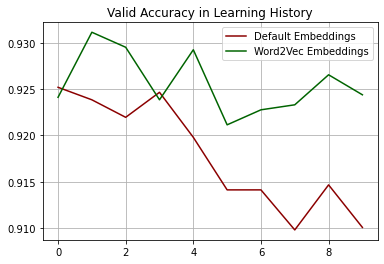

In [ ]:
plt.plot(history1.history['val_acc'], label='Default Embeddings', c='darkred')
plt.plot(history2.history['val_acc'], label='Word2Vec Embeddings', c='darkgreen')
plt.title('Valid Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()

**Выводы:**
 - при инициализации слоя эмбеддингов эмбеддингами Word2Vec свёрточная сеть даёт качество классификации несколько выше и переобучается на эпохах медленнее;
 - логистическая регрессия и градиентный бустинг на признаках, отобранных логистической регрессией, показали более высокую долю правильных ответов (0.93 и 0.92 соответственно);
 - для улучшения результатов следует проверить другие архитектуры сетей (а также - вообще другой тип сети).